# Preamble

In [1]:
%matplotlib inline

In [2]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import operator
import collections

import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.animation as animation
from matplotlib.transforms import ScaledTranslation

import numpy as np
import imageio
from tqdm import tqdm

# Plot functions

In [39]:
plt.rcParams.update({
    "animation.writer": "ffmpeg",
    "font.family": "serif",  # use serif/main font for text elements
    "font.size": 12,
    "text.usetex": True,     # use inline math for ticks
    "text.latex.preamble": r"\usepackage{amsmath}",
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
    "hist.bins": 20, # default number of bins in histograms
    "pgf.preamble": [
         "\\usepackage{units}",          # load additional packages
         "\\usepackage{metalogo}",
         "\\usepackage{unicode-math}",   # unicode math setup
         r"\setmathfont{xits-math.otf}",
         r"\setmainfont{DejaVu Serif}",  # serif font via preamble
         r'\usepackage{color}',
    ]
})

In [4]:
def rotate_point(x, y, angle_deg):
    cos,sin = np.cos(angle_deg*np.pi/180),np.sin(angle_deg*np.pi/180)
    return cos*x-sin*y,sin*x+cos*y

def draw_brace(ax, span, position, text, text_pos, brace_scale=1.0, beta_scale=300., rotate=False, 
               rotate_text=False, color='black', fontsize=16, linewidth=1.):
    '''
        all positions and sizes are in axes units
        span: size of the curl
        position: placement of the tip of the curl
        text: label to place somewhere
        text_pos: position for the label
        beta_scale: scaling for the curl, higher makes a smaller radius
        rotate: anngle of rotation for the curl
        rotate_text: angle of rotation for the text       
    '''
    # get the total width to help scale the figure
    ax_xmin, ax_xmax = ax.get_xlim()
    xax_span = ax_xmax - ax_xmin
    resolution = int(span/xax_span*100)*2+1 # guaranteed uneven
    beta = beta_scale/xax_span # the higher this is, the smaller the radius
    # center the shape at (0, 0)
    x = np.linspace(-span/2., span/2., resolution)
    # calculate the shape
    x_half = x[:int(resolution/2)+1]
    y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
    y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
    # put the tip of the curl at (0, 0)
    max_y = np.max(y)    
    min_y = np.min(y)
    y /= (max_y-min_y)
    y *= brace_scale
    y -= max_y
    # rotate the trace before shifting
    x,y = rotate_point(x, y, rotate)
    # shift to the user's spot   
    x += position[0]        
    y += position[1]
    ax.autoscale(False)
    ax.plot(x, y, clip_on=False, color=color, lw=linewidth)
    # put the text
    ax.text(text_pos[0], text_pos[1], text, ha='center', va='bottom', rotation=rotate_text, color=color, fontsize=fontsize) 

In [5]:
def draw_unfinished_brace(ax, span, position, text, text_pos, brace_scale=1.0, beta_scale=300., rotate=False, 
               rotate_text=False, color='black', fontsize=16, linewidth=1., extra_dash=0.1):
    '''
        all positions and sizes are in axes units
        span: size of the curl
        position: placement of the tip of the curl
        text: label to place somewhere
        text_pos: position for the label
        beta_scale: scaling for the curl, higher makes a smaller radius
        rotate: anngle of rotation for the curl
        rotate_text: angle of rotation for the text       
    '''
    # get the total width to help scale the figure
    ax_xmin, ax_xmax = ax.get_xlim()
    xax_span = ax_xmax - ax_xmin
    resolution = int(span/xax_span*100)*2+1 # guaranteed uneven
    beta = beta_scale/xax_span # the higher this is, the smaller the radius
    # center the shape at (0, 0)
    x = np.linspace(-span/2., span/2., resolution)
    x_extended = np.linspace(-span*(0.5+extra_dash), span*0.5, (int)((1+extra_dash)*resolution))
    # calculate the shape
    x_half = x[:int(resolution/2)+1]
    y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
    remove = int(0.2*len(x))
    y_extended = np.concatenate((y_half_brace[remove:], y_half_brace[-2::-1]))
    extra_length = len(x_extended)-len(y_extended)
    y_extended = np.concatenate((y_extended[0]*np.ones(extra_length), y_extended))
    # put the tip of the curl at (0, 0)
    max_y = np.max(y_extended)    
    min_y = np.min(y_extended)
    y_extended /= (max_y-min_y)
    y_extended *= brace_scale
    y_extended -= max_y
    # rotate the trace before shifting
    x_extended,y_extended = rotate_point(x_extended, y_extended, rotate)
    # shift to the user's spot   
    x_extended += position[0]        
    y_extended += position[1]
    ax.autoscale(False)
    dashed_length = len(x_extended)-resolution
    ax.plot(x_extended[dashed_length:], y_extended[dashed_length:], clip_on=False, color=color, lw=linewidth)
    ax.plot(x_extended[:dashed_length], y_extended[:dashed_length], clip_on=False, color=color, lw=linewidth, linestyle=(0, (5, 5)))
    # put the text
    ax.text(text_pos[0], text_pos[1], text, ha='center', va='bottom', rotation=rotate_text, color=color, fontsize=fontsize) 

# Network architecture

In [6]:
class Net(torch.nn.Module):
    """
    1 hidden layer Relu network architecture
    """
    def __init__(self, n_hidden, n_feature=1, n_output=1, bias_hidden=True, skip_connection=True, **kwargs):
        """
        n_hidden: number of hidden neurons
        n_feature: dimension of input
        n_output: dimension of output
        bias_hidden: if True, use bias parameters in hidden layer. Use no bias otherwise
        skip_connection: if True, add a (free) affine term in the represented function
        """
        super(Net, self).__init__()
        self.bias_hidden_ = bias_hidden
        
        self.skip_ = skip_connection
        
        self.hidden = torch.nn.Linear(n_feature, n_hidden, bias=bias_hidden)   # hidden layer            
        self.predict = torch.nn.Linear(n_hidden, n_output, bias=False)   # output layer
        self.activation = kwargs.get('activation', torch.nn.ReLU()) # activation of hidden layer
        if self.skip_:
            self.skip = torch.nn.Linear(n_feature, n_output, bias=True)   # affine term     

    def forward(self, z):
        z1 = self.activation(self.hidden(z))    
        z1 = self.predict(z1)
        if self.skip_:
            z1 += self.skip(z)
        return z1
    
    def weight_norm(self, bias=True):
        """
        Return the total squared L2 norm of the parameters
        bias: if True, count the bias weight in the L2 norm
        """
        if bias:
            sq_hidden_norms = (self.hidden.weight.data.norm(dim=1).square()+self.hidden.bias.data.square()).sum()
        else:
            sq_hidden_norms = self.hidden.weight.data.norm(dim=1).square().sum()
        sq_output_norms = self.predict.weight.data.square().sum()
        return (sq_hidden_norms+sq_output_norms)/2
        
    def balance(self, bias=True):
        """
        make the weights of the hidden and output layer balanced (useful to minimise the L2 norm of the parameters)
        bias: if True, count the bias weight in the L2 norm
        """
        if bias:
            hidden_norms = (self.hidden.weight.data.norm(dim=1).square()+self.hidden.bias.data.square()).sqrt().reshape(1,-1)
        else:
            hidden_norms = (self.hidden.weight.data.norm(dim=1).square()).sqrt().reshape(1,-1)
        output_norms = self.predict.weight.data.abs()
        
        #avoid division by 0
        hidden_norms[hidden_norms==0] = 1
        output_norms[output_norms==0] = 1
        
        c = (output_norms/hidden_norms).sqrt()
        self.hidden.weight.data *= c.T
        if self.bias_hidden_:
            self.hidden.bias.data *= c.reshape(-1)
        self.predict.weight.data /= c.reshape(-1)

# Generating data

In [7]:
def generate_convex_sequence(npoints, x0=None, delta0=None, xmaxdiff=1, deltamaxdiff=1, xmindiff=0, deltamindiff=0):
    """
    return a sequence of points (x_i, delta_i) such that the piecewise linear interpolation 
    is convex on the whole interval (x_min, x_max).
    The delta_i give the slope of the piecewise linear interpolation on the interval (x_i, x_{i+1})
    It does so by generating increments of x and delta as unfiorm random variables.
    xmaxdiff: max range of x increments
    xmindiff: min range of x increments
    x0: fix first value of x. If None, choose one uniformly at random in (-1,1)
    deltamaxdiff: max range of delta increments
    deltamindiff: min range of delta increments
    delta0: fix first value of delta. If None, choose one uniformly at random in (-1,1)
    """
    
    if x0 is None:
        x0 = np.random.uniform(low=-1,high=1)
    x = x0*np.ones(npoints)
    xincr = np.random.uniform(low=xmindiff, high=xmaxdiff, size=npoints-1)
    x[1:]+=xincr.cumsum()
    
    
    if delta0 is None:
        delta0 = np.random.uniform(low=-1,high=1)
    delta = delta0*np.ones(npoints-1)
    deltaincr = np.random.uniform(low=deltamindiff, high=deltamaxdiff, size=npoints-2)    
    delta[1:]+=deltaincr.cumsum()
    
    return x,delta

def deltas_to_ys(x,delta,y0=0):
    """
    return a sequence of points y_i such that the sequence (coordinates,values) = (x,y) 
    corresponds to the sequence (coordinate, slope) = (x, delta).
    y0: value of the first y.
    """
    y = y0*np.ones(len(x))
    yincr = delta*(x[1:]-x[:-1])
    y[1:] += np.cumsum(yincr)
    return y

# Solving min norm interpolator

In [8]:
def g(x1,x0,delta):
    return lambda s1,s0 : np.sqrt((x1*(s1.reshape(-1,1)-delta)-x0*(s0.reshape(1,-1)-delta))**2+(s1.reshape(-1,1)-s0.reshape(1,-1))**2)

In [9]:
def min_norm_interpolator(x, delta, grid_size=100, return_cost=False):
    """
    Given the (coordinates, slopes) sequence (x,delta), return the sequence of slope (s_i) minimising the dynamic program.
    Since the dynamic program is continuous, we approximate it by discretising the intervals (delta_i,delta_{i+1})
    grid_size: number of points in the discretisation of (delta_i,delta_{i+1}) at each iteration
    return_cost: if True, also return the approximations of c_i as a matrix as well as the total cost of the associated interpolator
    """
    n = len(x)
    i0 = np.searchsorted(x, 0, side='right', sorter=None)
    cost = np.zeros((n, grid_size))
    
    slope = np.zeros((n, grid_size), dtype=int) # argmin associated to the costs c_i
    
    grid = np.zeros((n, grid_size))
    grid[0,:] = delta[0]
    grid[-1,:] = delta[-1]
    
    for i in range(1,n-1):
        if (i>=2) and (np.sign(delta[i]-delta[i-1])*np.sign(delta[i-2]-delta[i-1])>=0):
            grid[i,:] = delta[i-1]
        else:
            grid[i,:] = np.linspace(delta[i-1],delta[i],grid_size)
    
    for i in range(0,i0-1):
        #compute c^-_{i+1}
        s0 = grid[i,:]
        s1 = grid[i+1,:]
        g1 = g(x[i+1],x[i],delta[i])
        cost[i+1,:] = np.min(g1(s1,s0)+cost[i,:].reshape(1,-1),axis=1)
        slope[i+1,:] = np.argmin(g1(s1,s0)+cost[i,:].reshape(1,-1),axis=1)
        
        # handle the case s_i = delta_i
        k1 = np.min((np.searchsorted(grid[i,:],delta[i]),grid_size-1))
        k2 = np.min((np.searchsorted(grid[i+1,:],delta[i]),grid_size-1))
        cost[i+1,k2] = cost[i,k1]
        slope[i+1,k2] = k1
        
    for j in range(1,n-i0):
        # compute c^+_i
        i = n-j-1
        s0 = grid[i,:]
        s1 = grid[i+1,:]
        g1 = g(x[i+1],x[i],delta[i])
        cost[i,:] = np.min(g1(s1,s0)+cost[i+1,:].reshape(-1,1),axis=0)
        slope[i,:] = np.argmin(g1(s1,s0)+cost[i+1,:].reshape(-1,1),axis=0)
        
        # handle the case s_i = delta_i
        k1 = np.min((np.searchsorted(grid[i,:],delta[i]),grid_size-1))
        k2 = np.min((np.searchsorted(grid[i+1,:],delta[i]),grid_size-1))
        cost[i,k1] = cost[i+1,k2]
        slope[i,k1] = k2
    
    s_index = np.zeros(n, dtype=int) # minimal sequence of slopes as indices
    
    #compute optimal slopes at x_{i0-1} and x_{i0}
    if (i0>0 and i0<n):
        i = i0-1
        s0 = grid[i,:]
        s1 = grid[i+1,:]
        g1 = g(x[i+1],x[i],delta[i])
        Z = g1(s1,s0)+cost[i+1,:].reshape(-1,1)+cost[i,:].reshape(1,-1)
        c = np.min(Z)
        k1,k0 = np.unravel_index(np.argmin(Z, axis=None), Z.shape)
        s_index[i0] = k1
        s_index[i0-1] = k0
    elif i0==0:
        s_index[i0]=0
        c = np.min(cost[0,:])
    else: #i0==n
        s_index[i0-1]=0
        c = np.min(cost[i0-1,:])
        
    for j in range(1,i0):
        i=i0-j-1
        s_index[i]=slope[i+1,s_index[i+1]]
    for i in range(i0,n-1):
        s_index[i+1]=slope[i,s_index[i]]
        
    s = np.zeros(n) # minimal sequence of slopes
    for i in range(0,n):
        s[i] = grid[i,s_index[i]]
    
    if return_cost:
        return s,cost,c
    else:
        return s

In [10]:
def slopes_to_network(x, y, s, balanced=True):
    """
    From an appropriate sequence of slopes s, return a corresponding neural network 
    interpolating the data (x,y).
    We use for this the mapping given in the Appendix.
    balanced: if True, return a balanced network
    """
    n = len(x)
    net = Net(n-1)
    for w in net.parameters(): # set all weights to 0
        torch.nn.init.zeros_(w.data)
    
    # affine term
    net.skip.weight.data[0,0] = s[0]
    net.skip.bias.data[0]=y[0]-s[0]*x[0]
    
    #ReLU terms
    torch.nn.init.ones_(net.hidden.weight.data)
    for i in range(0,n-1):
        # a_i
        net.predict.weight.data[0,i] = s[i+1]-s[i]
        # tau_i
        if (s[i+1]!=s[i]):
            net.hidden.bias.data[i] = -x[i+1]+(y[i+1]-y[i]-s[i]*(x[i+1]-x[i]))/(s[i+1]-s[i])
        else:
            net.hidden.weight.data[i] = 0
            
        
    if balanced:
        net.balance()
        
    return net

# Illustration

In [11]:
n=6
np.random.seed(2)
(x,delta) = generate_convex_sequence(n, xmindiff=0.2, xmaxdiff=1, x0=0,deltamindiff=0.5,deltamaxdiff=1,delta0=-1)
y = deltas_to_ys(x,delta)
print(delta)

[-1.         -0.33483259  0.26749173  1.07712721  1.72695455]


In [12]:
s,cost,c = min_norm_interpolator(x,delta,return_cost=True, grid_size=100)
#print(s)
net1 = slopes_to_network(x, y, s, balanced=False) # min norm interpolator

In [13]:
s = np.array([delta[0], delta[0], delta[2], delta[2], delta[4], delta[4]])
net2 = slopes_to_network(x, y, s, balanced=True) # sparsest interpolator

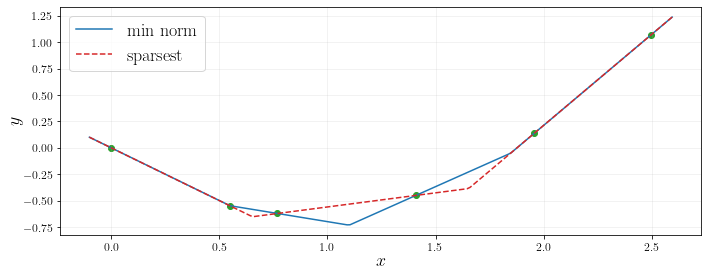

In [15]:
z = torch.Tensor(np.linspace(x[0]-0.1,x[-1]+0.1,200).reshape(-1,1))
# view data
plt.figure(figsize=(10,4))
plt.scatter(x, y, color = "tab:green")
plt.plot(z.data.numpy(), net1(z).data.numpy(), color = "tab:blue", label="min norm")
plt.plot(z.data.numpy(), net2(z).data.numpy(), '--', color = "tab:red", label="sparsest")
plt.xlabel(r'$x$', labelpad=0, fontsize=18)
plt.ylabel(r'$y$', labelpad=0, fontsize=18)
plt.grid(alpha=0.2)
plt.legend(fontsize=18)
plt.tight_layout()
plt.savefig('nosparse.pdf')
plt.show()

### Sparsest recovery criterion

In [16]:
i=2
u0 = np.array([x[i],1])
u1 = np.array([x[i+1],1])
w0 = np.array([x[i]*(delta[i]-delta[i-1])/(delta[i]-delta[i-2])+x[i-1]*(delta[i-1]-delta[i-2])/(delta[i]-delta[i-2]),1])
w1 = np.array([x[i+2]*(delta[i+2]-delta[i+1])/(delta[i+2]-delta[i])+x[i+1]*(delta[i+1]-delta[i])/(delta[i+2]-delta[i]),1])
a1 = np.sum(u0*u0)-np.sum(u0*w0)**2/np.sum(w0*w0)
a2 = np.sum(u1*u1)-np.sum(u1*w1)**2/np.sum(w1*w1)
a3 = np.sum(u0*u1) - np.sum(u0*w0)*np.sum(u1*w1)/(np.linalg.norm(w0)*np.linalg.norm(w1))
print("Sparse recovery criterion satisfied: ", -a3 <= np.sqrt(a1*a2))

Sparse recovery criterion satisfied:  False


In [17]:
print("Weight norm of sparsest network: ", net2.weight_norm().data.numpy())
net1.balance()
print("Weight norm of min interpolator: ", net1.weight_norm().data.numpy())

Weight norm of sparsest network:  4.3343506
Weight norm of min interpolator:  4.323781


In [18]:
print("Do they interpolate?")
print("Training loss of sparse network: ", (net2(torch.Tensor(x).reshape(-1,1))-torch.Tensor(y).reshape(-1,1)).norm().data.numpy())
print("Training loss of min norm network: ", (net1(torch.Tensor(x).reshape(-1,1))-torch.Tensor(y).reshape(-1,1)).norm().data.numpy())

Do they interpolate?
Training loss of sparse network:  1.8189185e-07
Training loss of min norm network:  1.8189185e-07


# Partitioned case

In [19]:
np.random.seed(0)
n_list = [3, 2, 3, 3]
sign_list = [1, 0, 1, -1]
xminincr,xmaxincr = 0.2,1
dminincr,dmaxincr = 0.5,1
last_n = 0
delta0 = -2
x0 = -4

n_points = np.sum(n_list)
x = np.zeros(n_points)
delta = np.zeros(n_points-1)

for i in range(len(n_list)):
    incr = n_list[i]
    n = incr + last_n
    s = sign_list[i]
    if s==1:
        (x_n,delta_n) = generate_convex_sequence(incr+2,xmindiff=xminincr,xmaxdiff=xmaxincr,x0=x0,deltamindiff=dminincr,deltamaxdiff=dmaxincr,delta0=delta0)
    elif s==-1:
        (x_n,delta_n) = generate_convex_sequence(incr+2,xmindiff=xminincr,xmaxdiff=xmaxincr,x0=x0,deltamindiff=-dmaxincr,deltamaxdiff=-dminincr,delta0=delta0)
    elif s==0:
        (x_n,delta_n) = generate_convex_sequence(incr+2,xmindiff=xminincr,xmaxdiff=xmaxincr,x0=x0,deltamindiff=0,deltamaxdiff=0,delta0=delta0)
    x[last_n:n] = x_n[1:-1]
    if n==n_points:
        delta[last_n:n-1] = delta_n[1:-1]
    else:
        delta[last_n:n] = delta_n[1:]
    x0 = x_n[-2]
    delta0 = delta_n[-1]
    last_n = n
    
y = deltas_to_ys(x,delta)
print(delta)

[-1.2881726  -0.46522554  0.25356806  0.25356806  0.25356806  0.76367726
  1.67998718  2.56906556  1.95933015  1.01846736]


In [20]:
s,cost,c = min_norm_interpolator(x,delta,return_cost=True, grid_size=100)
#print(s)
net = slopes_to_network(x, y, s, balanced=False)

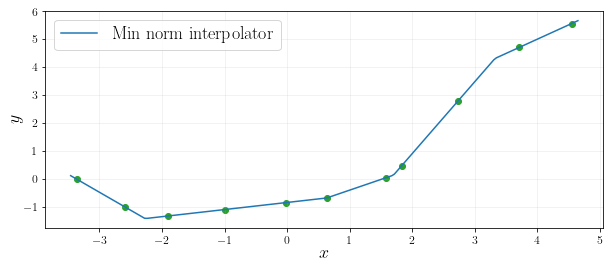

In [21]:
z = torch.Tensor(np.linspace(x[0]-0.1,x[-1]+0.1,200).reshape(-1,1))
# view data
plt.figure(figsize=(10,4))
plt.scatter(x, y, color = "tab:green")
plt.plot(z.data.numpy(), net(z).data.numpy(), color = "tab:blue", label="Min norm interpolator")
plt.grid(alpha=0.2)
plt.xlabel(r'$x$', labelpad=0, fontsize=18)
plt.ylabel(r'$y$', labelpad=0, fontsize=18)
plt.legend(fontsize=18)
plt.savefig('partitioned_case.pdf')
plt.show()

In [22]:
print("Number of kinks: " + str(np.sum(net.predict.weight.data.numpy()!=0)))

Number of kinks: 4


# Illustration of the partitioning

In [23]:
s_lin = np.concatenate((delta[0].reshape(-1),delta))
net_lin = slopes_to_network(x, y, s_lin, balanced=False)
partition_x = np.array((x[0],x[1],x[3],x[5],x[8],x[10]))
partition = np.array((0,1,3,5,8,10))

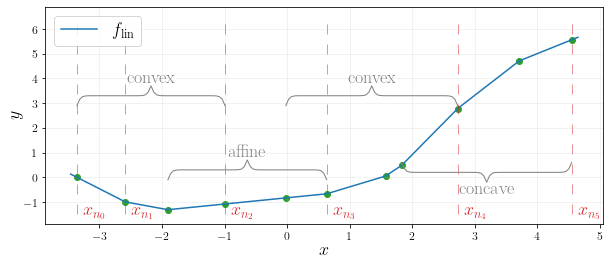

In [24]:
z = torch.Tensor(np.linspace(x[0]-0.1,x[-1]+0.1,200).reshape(-1,1))
shapes = ['convex', 'affine', 'convex', 'concave']
y_positions=[4,1,4,-0.5]
rotates=[0,0,0,180]
# view data
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.grid(alpha=0.2)
ax.scatter(x, y, color = "tab:green")
ax.plot(z.data.numpy(), net_lin(z).data.numpy(), color = "tab:blue", label=r'$f_{\mathrm{lin}}$')
ax.vlines(partition_x, ymin=-1.5, ymax=6.5, linewidth=0.5, color = "tab:red", linestyle=(0, (20,20)))
ax.set_xlabel(r'$x$', labelpad=0, fontsize=18)
ax.set_ylabel(r'$y$', labelpad=0, fontsize=18)
for k,i in enumerate(partition):
    ax.annotate(r'$x_{'+r'n_{{{0}}}'.format(k)+r'}$', (x[i]+0.1,-1.5), color="tab:red", fontsize=18)
    if k>1:
        x1, x0 = x[i], x[partition[k-1]-1]
        gap, xpos = x1-x0, (x1+x0)/2
        ypos = y_positions[k-2]
        draw_brace(ax, gap, (xpos,ypos), shapes[k-2], (xpos,ypos-0.3), brace_scale=0.8, color="tab:grey", fontsize=18, rotate=rotates[k-2])
ax.legend(fontsize=18)
fig.savefig('partition.pdf')
plt.show()

# Test with very large convex regions

In this part, we generate $n_{\text{test}}$ random data sequences with convex region of $n$ points. We then compute the minimal norm interpolator for each of these sequences and count its number of kinks. We then look at the repartition of the number of kinks over all the generated sequences. Note that it should be between $17$ (which corresponds to the sparsest interpolators) and $34$ (thanks to the upper bound given by Lemma 1).

In [32]:
kinks = dict()
n=35
ntest = 10000
for hh in range(ntest):
    n=35
    (x,delta) = generate_convex_sequence(n, xmindiff=0.2, xmaxdiff=2, x0=-4,deltamindiff=0.2,deltamaxdiff=2,delta0=0)
    y = deltas_to_ys(x,delta)
    s,cost,c = min_norm_interpolator(x,delta,return_cost=True, grid_size=100)
    net = slopes_to_network(x, y, s, balanced=False)
    nk = net.predict.weight.data.nonzero().shape[0]
    kinks[nk] = kinks.get(nk,0)+1

In [33]:
sorted_kinks = sorted(kinks.items(), key=operator.itemgetter(0))
nkinks = dict()
for s1,s2 in sorted_kinks:
    nkinks[s1] = s2
del(sorted_kinks)

In [34]:
nkinks

{17: 10,
 18: 123,
 19: 771,
 20: 2126,
 21: 2914,
 22: 2350,
 23: 1192,
 24: 397,
 25: 95,
 26: 19,
 27: 2,
 28: 1}

# Illustration of DP

In [36]:
x = np.array([0.25, 0.7])
y = np.array([0.25,  0.75])
s = np.array([4, -0.5])
net_DP = slopes_to_network(x, y, s, balanced=False)

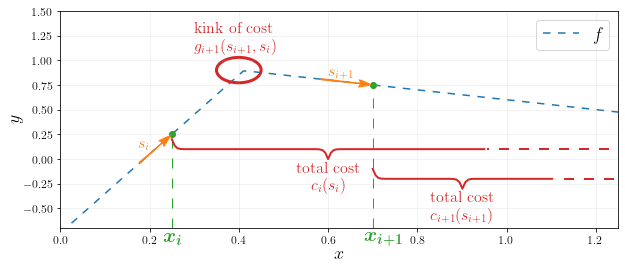

In [42]:
prop = dict(arrowstyle="fancy,head_width=0.6,head_length=1.,tail_width=0.1",
           color="tab:orange")
z = torch.Tensor(np.linspace(0,x[-1]+1,200).reshape(-1,1))
xi = [r'$\boldsymbol{x_{i}}$', r'$\boldsymbol{x_{i+1}}$']
si = [r'$s_{i}$', r'$s_{i+1}$']
al = [0.075,0.12]
adj= [[0.075,0.13],[0.1,-0.1]]
# view data
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.grid(alpha=0.2)
ax.scatter(x, y, color = "tab:green")
ax.plot(z.data.numpy(), net_DP(z).data.numpy(), color = "tab:blue", label=r'$f$', zorder=0, linestyle=(0, (5,5)))
ax.grid(alpha=0.2)
ax.set_xlabel(r'$x$', labelpad=0, fontsize=18)
ax.set_ylabel(r'$y$', labelpad=0, fontsize=18)
ax.set_ylim(-0.7, 1.5)
ax.set_xlim(0, 1.25)
ax.legend(fontsize=18)
ax.vlines(x, ymin=-.7, ymax=y, linewidth=1, color = "tab:green", linestyle=(0, (10,10)))

# circle for g_{i+1}
x0, y0 = ax.transAxes.transform((0, 0)) # lower left in pixels
x1, y1 = ax.transAxes.transform((1, 1)) # upper right in pixes
dx = x1 - x0
dy = y1 - y0
maxd = max(dx, dy)
width = .1 * maxd / dx
height = .1 * maxd / dy

# cost g_{i+1}
circle = patches.Ellipse((0.4, 0.9), width, height, facecolor='none',
                edgecolor="tab:red", linewidth=3)
ax.add_patch(circle)
ax.text(0.3,1.1, "kink of cost \n"+r'$g_{i+1}(s_{i+1},s_i)$', fontsize=16, color="tab:red")

for i in range(0,2):
    ax.text(x[i]-0.02,-0.83,xi[i], fontsize=20, color="tab:green")
    a = al[i]*np.array([1,s[i]])
    ax.annotate("", xy=(x[i],y[i]), xytext=(x[i]-a[0],y[i]-a[1]), arrowprops=prop,
               color="tab:orange", zorder=1)
    ax.text(x[i]-adj[i][0],y[i]-adj[i][1], si[i], fontsize=16,color="tab:orange")
    
# draw braces
xpos, ypos = 0.6, -1.2
gap = (xpos-x[0])*2
draw_unfinished_brace(ax, gap, (xpos, ypos), "total cost \n" + r'$c_i(s_i)$', (xpos,-0.35), brace_scale=0.2, beta_scale=300., 
                      color="tab:red", fontsize=16, rotate=180, extra_dash=0.4, linewidth=2) 
xpos, ypos = 0.9, -1.5
gap = (xpos-x[1])*2
draw_unfinished_brace(ax, gap, (xpos, ypos), "total cost \n" + r'$c_{i+1}(s_{i+1})$', (xpos,-0.65), brace_scale=0.2, beta_scale=300., 
                      color="tab:red", fontsize=16, rotate=180, extra_dash=0.35,linewidth=2)   

fig.savefig('DP.pdf')
plt.show()